# A simple tutorial to Stellar LAbel Machine (SLAM)

**Bo Zhang** (<mailto:bozhang@nao.cas.cn>), Created on Thu Jan 19 15:48:12 2017




In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from slam.slam import Slam
from slam.diagnostic import compare_labels
from slam.apogee import aspcapStar_read, apStar_read
from slam.normalization import normalize_spectrum, normalize_spectra_block
from slam.binning import interp_pchip, interp_linear, interp_nearest
from astropy.table import Table, Column
from joblib import Parallel, delayed, dump, load

os.chdir("/home/cham/PycharmProjects/slam/doc/example_DR10/Data")

In [3]:
""" load catalog """
t = Table.read('../reference_labels.csv')
label3 = np.array(t['Teff_{corr}', 'logg_{corr}', '[M/H]_{corr}'].to_pandas())

In [4]:
""" define functions """
def apStar_read_interp(fp, wave_interp, i_use=0):
    spec = apStar_read(fp, full=True, meta=True, verbose=False)
    wave_rest = spec['wave']#/(1+rv/299792.458)

    if spec.meta['NVISITS'] > 1:
        flux_interp = interp_linear(wave_rest, spec['flux'][:, i_use], wave_interp, 0)
        ivar_interp = (1./interp_linear(wave_rest, spec['flux_err'][:, i_use], wave_interp, 1E10))**2
        mask_interp = interp_nearest(wave_rest, spec['mask'][:, i_use], wave_interp, 1)
    else:
        flux_interp = interp_linear(wave_rest, spec['flux'], wave_interp, 0)
        ivar_interp = (1./interp_linear(wave_rest, spec['flux_err'], wave_interp, 1E10))**2
        mask_interp = interp_nearest(wave_rest, spec['mask'], wave_interp, 1)
    return flux_interp, ivar_interp, mask_interp

def apStar_read_block(fps, wave_interp, n_jobs=1, verbose=False):
    r = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(apStar_read_interp)(fp,wave_interp,0) for fp in fps)
    flux_block = np.array([_[0] for _ in r])
    ivar_block = np.array([_[1] for _ in r])
    mask_block = np.array([_[2] for _ in r])
    return flux_block, ivar_block, mask_block

def aspcapStar_read_interp(fp, wave_interp, i_use=0):
    spec = aspcapStar_read(fp, meta=True)
    return spec['flux'], 1./spec['flux_err'].data**2.

def aspcapStar_read_block(fps, n_jobs=1, verbose=False):
    r = Parallel(n_jobs=n_jobs, verbose=verbose)(
        delayed(aspcapStar_read_interp)(fp,wave_interp,0) for fp in fps)
    flux_block = np.array([_[0] for _ in r])
    ivar_block = np.array([_[1] for _ in r])
    ivar_block = np.where(np.isfinite(ivar_block), ivar_block, np.zeros_like(ivar_block))
    return flux_block, ivar_block

In [5]:
""" define wavelength grid according to the first spectrum """
spec = aspcapStar_read(t['ID'][0], True, True)
wave_interp = spec['wave'].data

""" read all spectra """
flux_block, ivar_block = aspcapStar_read_block(t['ID'].data, n_jobs=-1)

""" normalization """
r1 = normalize_spectra_block(
    wave_interp, flux_block, (15200., 17000.), 30., p=(1E-8, 1E-7), q=0.7,
    eps=1E-19, ivar_block=flux_block > 0, rsv_frac=1., n_jobs=10, verbose=5)
flux_norm, flux_cont = r1
ivar_norm = flux_cont**2*ivar_block

@Cham: successfully load aspcapStar-v304-2M17162228+4258036.fits ...


[Parallel(n_jobs=10)]: Done 212 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 548 out of 548 | elapsed:    3.0s finished


In [6]:
""" training """
k = Slam(wave_interp, flux_norm, ivar_norm, label3)
# train: using simple user-defined hyper-parameters
# it takes ~2 min using 32 cores
k.train_pixels(method='simple', n_jobs=24, verbose=5, C=2.0, epsilon=0.1, gamma=1.)


@SLAM: updating data dimensions!
----------------------------------
n_obs: 0 --> 548
n_pix: 0 --> 8575
n_dim: 0 --> 3
----------------------------------


[Parallel(n_jobs=24)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 708 tasks      | elapsed:   12.4s
[Parallel(n_jobs=24)]: Done 1133 tasks      | elapsed:   19.8s
[Parallel(n_jobs=24)]: Done 1295 tasks      | elapsed:   23.5s
[Parallel(n_jobs=24)]: Done 1493 tasks      | elapsed:   27.9s
[Parallel(n_jobs=24)]: Done 1727 tasks      | elapsed:   32.9s
[Parallel(n_jobs=24)]: Done 1997 tasks      | elapsed:   39.1s
[Parallel(n_jobs=24)]: Done 2303 tasks      | elapsed:   45.7s
[Parallel(n_jobs=24)]: Done 2645 tasks      | elapsed:   52.8s
[Parallel(n_jobs=24)]: Done 3023 tasks      | elapsed:  1.0min
[Parallel(n_jobs=24)]: Done 3867 tasks      | elapsed:  1.2min
[Parallel(n_jobs=24)]: Done 4482 tasks      | elapsed:  1.4min
[Parallel(n_jobs=24)]: Done 4968 tasks      | elapsed:  1.6min
[Parallel(n_jobs=24)]: Done 5490 tasks      | elapsed:  1.8min
[Parallel(n_jobs=24)]: Done 6048 tasks      | elapsed:  2.0min
[Parallel(n_jobs=24)]: Done 7208 tasks      | elapsed:  2

            C   gamma       epsilon
count  8575.0  8575.0  8.575000e+03
mean      2.0     1.0  1.000000e-01
std       0.0     0.0  1.387860e-17
min       2.0     1.0  1.000000e-01
25%       2.0     1.0  1.000000e-01
50%       2.0     1.0  1.000000e-01
75%       2.0     1.0  1.000000e-01
max       2.0     1.0  1.000000e-01


[Parallel(n_jobs=24)]: Done 8575 out of 8575 | elapsed:  2.8min finished


In [7]:
""" test """
# here simply to test SLAM on training sample
slc = slice(0, flux_norm.shape[0], 20)
# 1. derive stellar parameters using template matching
# it takes a few minutes
label_init = k.predict_labels_quick(flux_norm[slc, :], ivar_norm[slc, :], n_jobs=24)
# 2. re-fine the initial guess
# it takes an hour ...
label_refined = k.predict_labels_multi(label_init, flux_norm[slc, :], ivar_norm[slc, :], n_jobs=24)

('@Cham: X_init=', array([[ 1.09788249, -0.11198596, -1.3316392 ]]), 'X_final=', array([ 1.37274615,  0.06478326, -1.41680907]), 'ier', 1)
('@Cham: X_init=', array([[-0.60688261, -1.1597816 , -1.11680318]]), 'X_final=', array([-0.60009336, -1.11664624, -1.1015546 ]), 'ier', 1)
('@Cham: X_init=', array([[ 0.77127634, -0.29264038, -1.30776853]]), 'X_final=', array([ 0.80358217, -0.41389269, -1.39520844]), 'ier', 1)
('@Cham: X_init=', array([[ 0.80003619,  0.0415703 , -0.54390713]]), 'X_final=', array([ 1.01204389,  0.12470748, -0.5739655 ]), 'ier', 1)
('@Cham: X_init=', array([[-0.89382   , -0.59072018, -0.40068312]]), 'X_final=', array([-1.03705869, -0.62673842, -0.3677735 ]), 'ier', 1)
('@Cham: X_init=', array([[-0.9870416 , -1.64754854, -1.59421656]]), 'X_final=', array([-0.88966434, -1.60787237, -1.59286646]), 'ier', 1)
('@Cham: X_init=', array([[ 1.89258005,  0.58353356, -0.80648449]]), 'X_final=', array([ 1.98698904,  0.44947405, -1.07034307]), 'ier', 1)
('@Cham: X_init=', array([[

In [10]:
""" plot results """
fig = compare_labels(label3[slc, :], label_refined, 'ASPCAP', 'SLAM')

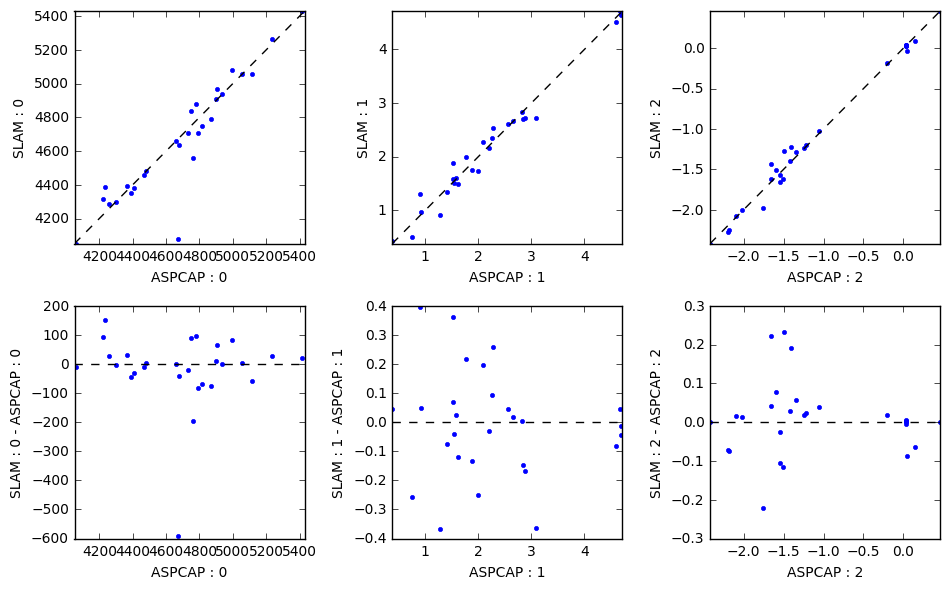

In [11]:
fig